In [98]:
#!pip install WordCloud

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation
from gensim.corpora import Dictionary
import pyLDAvis 
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import re
from gensim.models import CoherenceModel

In [2]:
# Download NLTK resources
nltk.download("stopwords")
nltk.download("wordnet")
nltk.download("vader_lexicon")
nltk.download("punkt")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [10]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
from datetime import datetime

def crawl_reddit(url, max_posts_per_url, post_urls):
    headers = {
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/134.0.0.0 Safari/537.36'
    }
    posts_data = []

    while len(posts_data) < max_posts_per_url:
        try:
            response = requests.get(url, headers=headers)
            response.raise_for_status()
            soup = BeautifulSoup(response.content, "html.parser")

            posts = soup.find_all("div", class_="thing")
            if not posts:
                print(f"No more posts found at {url}")
                break

            new_posts = False
            for post in posts:
                permalink = post.get("data-permalink", "")
                post_url = f"https://old.reddit.com{permalink}" if permalink else ""
                if post_url in post_urls:
                    continue
                post_urls.add(post_url)

                title_tag = post.find("a", class_="title")
                title = title_tag.text.strip() if title_tag else "No title"

                body = ""
                entry = post.find("div", class_="entry")
                if entry:
                    body_tag = entry.find("div", class_="md")
                    body = body_tag.text.strip() if body_tag else ""

                comments_tag = post.find("a", class_="comments")
                comments_count = int(comments_tag.text.split()[0]) if comments_tag and comments_tag.text.split()[0].isdigit() else 0

                score_tag = post.find("div", class_="score")
                upvotes = int(score_tag.text) if score_tag and score_tag.text.isdigit() else 0

                time_tag = post.find("time")
                post_time = pd.to_datetime(time_tag["datetime"]) if time_tag else pd.Timestamp.now()

                posts_data.append({
                    "title": title,
                    "body": body,
                    "comments_count": comments_count,
                    "upvotes": upvotes,
                    "datetime": post_time,
                    "url": post_url
                })
                new_posts = True

            if not new_posts:
                print(f"No new posts at {url}")
                break

            next_link = soup.find("span", class_="next-button")
            if not next_link or not next_link.find("a"):
                print(f"No next page at {url}")
                break
            url = next_link.find("a")["href"]
            print(f"Crawling {url}... Posts from this URL: {len(posts_data)}")
            time.sleep(2)

        except requests.exceptions.RequestException as e:
            print(f"Error fetching {url}: {e}")
            break
        except Exception as e:
            print(f"Error at {url}: {e}")
            break

    return posts_data

# Main crawling function with multiple sources
def crawl_multiple_sources(max_total_posts=1000):
    post_urls = set()  # Track unique posts
    all_posts = []

    # Subreddits to crawl
    subreddits = [
        "CovidVaccine",
        "COVID19",
        "Coronavirus",
        "Vaccine"  # Updated from CovidBooster to a more active subreddit
    ]
    subreddit_urls = [f"https://old.reddit.com/r/{sub}/hot/" for sub in subreddits]
    
    # Search terms for broader Reddit (updated to match your request)
    search_terms = ["covid19", "pfizer", "coronavirus", "moderna"]
    search_urls = [f"https://old.reddit.com/search?q={term}&sort=relevance&t=all" for term in search_terms]

    # Combine all URLs
    all_urls = subreddit_urls + search_urls
    max_posts_per_url = 500  # Higher limit per URL to ensure more posts

    # Crawl each URL
    for url in all_urls:
        if len(all_posts) >= max_total_posts:
            break
        print(f"Starting crawl for {url}")
        posts = crawl_reddit(url, max_posts_per_url, post_urls)
        all_posts.extend(posts)
        print(f"Total posts so far: {len(all_posts)}")

    # Save to DataFrame and CSV
    df = pd.DataFrame(all_posts)
    df = df.drop_duplicates(subset="url").reset_index(drop=True)  # Ensure uniqueness
    df.to_csv("reddit_vaccine_expanded_crawl.csv", index=False)
    print(f"Saved {len(df)} unique posts to 'reddit_vaccine_expanded_crawl.csv'")
    return df

# Run the crawler
df = crawl_multiple_sources(max_total_posts=1000)

Starting crawl for https://old.reddit.com/r/CovidVaccine/hot/
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=25&after=t3_rcoga4... Posts from this URL: 25
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=50&after=t3_qrh1ri... Posts from this URL: 50
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=75&after=t3_pwsajr... Posts from this URL: 75
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=100&after=t3_potorq... Posts from this URL: 100
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=125&after=t3_pf6ttm... Posts from this URL: 125
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=150&after=t3_p51uij... Posts from this URL: 150
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=175&after=t3_oxmcc5... Posts from this URL: 175
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=200&after=t3_opt0sv... Posts from this URL: 200
Crawling https://old.reddit.com/r/CovidVaccine/hot/?count=225&after=t3_nmpren... Posts from this

In [418]:
print(len(df))
df.drop_duplicates(subset=['title','url'],keep='first',inplace=True)
print(len(df))

1294
1294


In [209]:
# Text Preprocessing
#stop_words = set(stopwords.words("english"))
#df["text"] = df["title"] + " " + df["body"].fillna("")
#df["clean_text"] = df["text"].apply(lambda x: " ".join([w for w in re.sub(r"[^a-zA-Z\s]", "", re.sub(r"http\S+", "", x.lower())).split() if w not in stop_words]))

In [265]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing: Clean, tokenize, and lemmatize title
stop_words = set(stopwords.words("english"))
df["clean_text"] = df["title"].apply(
    lambda x: " ".join(
        [w for w in re.sub(r"[^a-zA-Z\s]", "", re.sub(r"http\S+", "", x.lower())).split() if w not in stop_words]
    )
)
df["tokens"] = df["clean_text"].apply(
    lambda x: [lemmatizer.lemmatize(token) for token in word_tokenize(x)]
)
print("Sample Lemmatized Tokens:\n", df["tokens"].head())

Sample Lemmatized Tokens:
 0    [extreme, health, anxiety, can, not, take, any...
1    [ive, told, get, vaccinated, many, year, can, ...
2             [ive, delayed, getting, nd, shot, month]
3       [reused, syringe, receiving, vaccine, booster]
4    [hey, wondering, got, one, jab, decided, get, ...
Name: tokens, dtype: object


In [269]:
df.clean_text

0              extreme health anxiety cannot take anymore
1       ive told get vaccinated many years cannot get ...
2                      ive delayed getting nd shot months
3                reused syringe receiving vaccine booster
4       hey wondering got one jab decided get second o...
                              ...                        
1269    winter coronavirus covid infection study estim...
1270    penn study finds serotonin reduction causes lo...
1271    covid antiviral uptake low among eligible amer...
1272    reversal us heighten efforts collect billions ...
1273    zapping vagus nerve could relieve long covid s...
Name: clean_text, Length: 1274, dtype: object

In [271]:
# Sentiment Analysis on title
sia = SentimentIntensityAnalyzer()
df["sentiment"] = df["title"].apply(lambda x: sia.polarity_scores(x)["compound"])
df["sentiment_label"] = df["sentiment"].apply(
    lambda x: "Positive" if x > 0.05 else "Negative" if x < -0.05 else "Neutral"
)
print("Sentiment Sample:\n", df[["title", "sentiment", "sentiment_label"]].head())

Sentiment Sample:
                                                title  sentiment  \
0   EXTREME health anxiety, cannot take this anymore    -0.1779   
1  I’ve been told not to get vaccinated for many ...     0.0000   
2        I’ve delayed getting my 2nd shot for months    -0.2263   
3      Reused syringe when receiving vaccine booster     0.0000   
4  Hey! Just wondering who only got the one jab a...    -0.5166   

  sentiment_label  
0        Negative  
1         Neutral  
2        Negative  
3         Neutral  
4        Negative  


C:\Users\brian\AppData\Local\Temp\ipykernel_9288\3063906846.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x="sentiment_label", order=["Positive", "Neutral", "Negative"], palette="viridis")


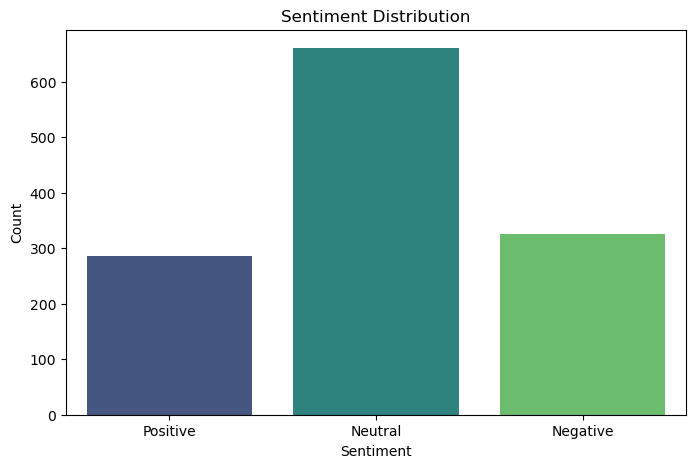

Sentiment Counts:
 sentiment_label
Neutral     661
Negative    326
Positive    287
Name: count, dtype: int64


In [273]:
# Visualization: Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x="sentiment_label", order=["Positive", "Neutral", "Negative"], palette="viridis")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.savefig("sentiment_dist.png")
plt.show()
print("Sentiment Counts:\n", df["sentiment_label"].value_counts())

In [275]:
# Topic Modeling
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)
feature_names = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    print(f"Topic #{idx + 1}:")
    print(" ".join([feature_names[i] for i in topic.argsort()[-10:][::-1]]))

Topic #1:
covid sarscov surge long high pfizer summer cases new anxiety
Topic #2:
thread discussion sarscov week covid weekly infection monthly scientific postacute
Topic #3:
covid vaccine pfizer shot know vaccines pandemic moderna booster dose
Topic #4:
covid vaccine vaccination sarscov vaccinated getting infection postcovid effects heart
Topic #5:
covid vaccine long study sarscov pandemic immune mrna brain patients


In [277]:
# TF-IDF Vectorization for LDA
vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])

# LDA Model
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# Calculate term frequencies using CountVectorizer
count_vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X_counts = count_vectorizer.fit_transform(df["clean_text"])
term_frequency = np.asarray(X_counts.sum(axis=0)).flatten()  # Sum term counts across documents

# Updated pyLDAvis visualization
vis_data = pyLDAvis.prepare(
    topic_term_dists=lda.components_ / lda.components_.sum(axis=1)[:, None],  # This will normalize the topic-term distribution
    doc_topic_dists=lda.transform(X),
    doc_lengths=df["clean_text"].apply(len),
    vocab=vectorizer.get_feature_names_out(),
    term_frequency=term_frequency,  # Here we add term frequencies
    R=10  # Top terms/topic
)
pyLDAvis.display(vis_data)

In [301]:
# Download NLTK required resources
nltk.download("punkt_tab")

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [302]:
df["tokens"] = df["clean_text"].apply(word_tokenize)
print("Sample Tokens:\n", df["tokens"].head())

Sample Tokens:
 0    [extreme, health, anxiety, can, not, take, any...
1    [ive, told, get, vaccinated, many, years, can,...
2            [ive, delayed, getting, nd, shot, months]
3       [reused, syringe, receiving, vaccine, booster]
4    [hey, wondering, got, one, jab, decided, get, ...
Name: tokens, dtype: object


In [305]:
feature_names = vectorizer.get_feature_names_out()

# Coherence Score
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
coherence_model = CoherenceModel(
    topics=[feature_names[topic.argsort()[-10:][::-1]].tolist() for topic in lda.components_],
    texts=df["tokens"],
    dictionary=dictionary,
    coherence="c_v"
)
print(f"LDA Coherence Score: {coherence_model.get_coherence():.3f}")

LDA Coherence Score: 0.298


In [307]:
# Word Frequency
word_freq = Counter(" ".join(df["clean_text"]).split()).most_common(20)
print("Top Words:", word_freq)

Top Words: [('covid', 706), ('vaccine', 204), ('sarscov', 204), ('long', 152), ('study', 114), ('infection', 94), ('vaccination', 81), ('vaccines', 67), ('new', 67), ('pandemic', 59), ('thread', 51), ('risk', 51), ('patients', 51), ('discussion', 50), ('health', 48), ('us', 48), ('get', 47), ('cohort', 42), ('mrna', 41), ('symptoms', 39)]


Top Words: [('covid', 706), ('vaccine', 204), ('sarscov', 204), ('long', 152), ('study', 114), ('infection', 94), ('vaccination', 81), ('vaccines', 67), ('new', 67), ('pandemic', 59), ('thread', 51), ('risk', 51), ('patients', 51), ('discussion', 50), ('health', 48), ('us', 48), ('get', 47), ('cohort', 42), ('mrna', 41), ('symptoms', 39)]


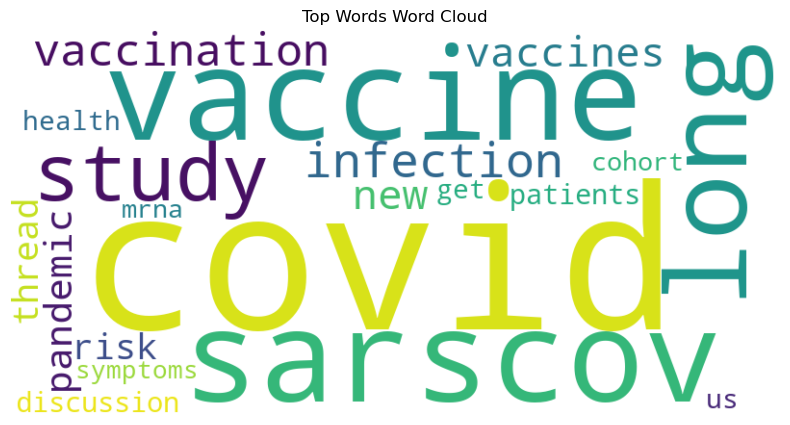

In [309]:
 # Word Frequency and Word Cloud
word_freq = Counter(" ".join(df["clean_text"]).split()).most_common(20)
print("Top Words:", word_freq)
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(dict(word_freq))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Top Words Word Cloud")
plt.show()

Sample Datetime Values:
 0   2022-01-07 03:47:47+00:00
1   2022-01-07 00:55:38+00:00
2   2022-01-04 20:25:04+00:00
3   2022-01-04 18:48:05+00:00
4   2021-12-29 08:42:45+00:00
Name: datetime, dtype: datetime64[ns, UTC]
Null Datetime Values: 0


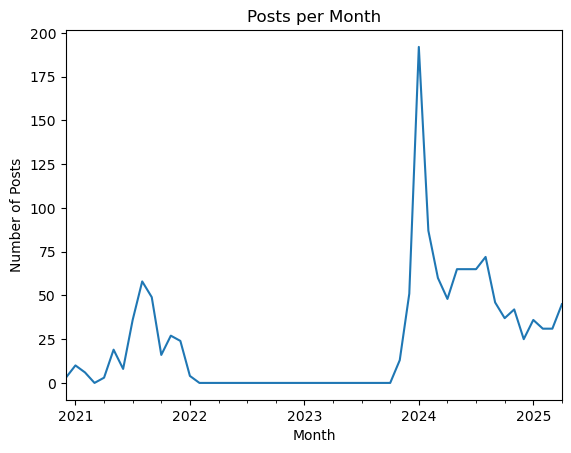

In [313]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert datetime with UTC standardization
df["datetime"] = pd.to_datetime(df["datetime"], errors="coerce", format="mixed", utc=True)
print("Sample Datetime Values:\n", df["datetime"].head())
print("Null Datetime Values:", df["datetime"].isnull().sum())

# EDA: Time Series
monthly_posts = df.resample("ME", on="datetime").size()  # ME = Month End
monthly_posts.plot(title="Posts per Month")
plt.xlabel("Month")
plt.ylabel("Number of Posts")
plt.savefig("posts_per_month.png")
plt.show()

C:\Users\brian\AppData\Local\Temp\ipykernel_9288\1029927449.py:2: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df.groupby(df["datetime"].dt.to_period("M"))["sentiment"].mean().plot(title="Average Sentiment Over Time")


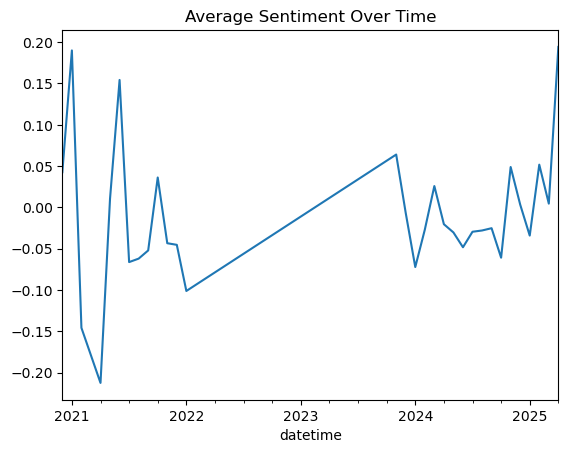

In [315]:
# Sentiment vs. Time
df.groupby(df["datetime"].dt.to_period("M"))["sentiment"].mean().plot(title="Average Sentiment Over Time")
plt.show()

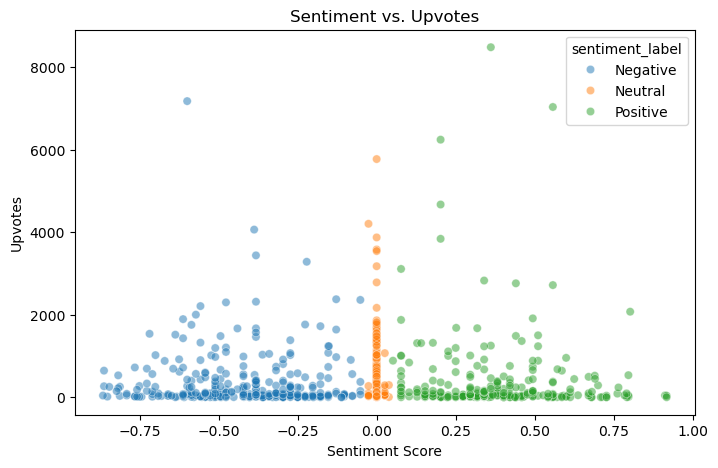

In [317]:
# Additional EDA: Sentiment vs. Upvotes
plt.figure(figsize=(8, 5))
sns.scatterplot(data=df, x="sentiment", y="upvotes", hue="sentiment_label", alpha=0.5)
plt.title("Sentiment vs. Upvotes")
plt.xlabel("Sentiment Score")
plt.ylabel("Upvotes")
plt.show()

In [327]:
from sklearn.decomposition import NMF

In [329]:
# NMF Model
nmf = NMF(n_components=5, random_state=42, init="nndsvd")  # nndsvd for faster convergence
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_  # Topic-term matrix

# Print top terms per topic
for i, topic in enumerate(H):
    top_terms = [feature_names[idx] for idx in topic.argsort()[-10:][::-1]]
    print(f"Topic {i + 1}: {', '.join(top_terms)}")


Topic 1: vaccine, covid, getting, people, mrna, arm, heart, question, xbb, questions
Topic 2: thread, discussion, weekly, week, scientific, monthly, march, february, april, january
Topic 3: covid, long, study, pandemic, vaccines, new, symptoms, patients, health, years
Topic 4: sarscov, infection, vaccination, risk, study, sequelae, postacute, cohort, omicron, immune
Topic 5: pfizer, dose, second, moderna, effects, shot, nd, booster, st, symptoms


In [331]:
# Coherence Score
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
coherence_model = CoherenceModel(
    topics=[feature_names[topic.argsort()[-10:][::-1]].tolist() for topic in H],
    texts=df["tokens"],
    dictionary=dictionary,
    coherence="c_v"
)
print(f"NMF Coherence Score: {coherence_model.get_coherence():.3f}")

NMF Coherence Score: 0.482


In [381]:
#!pip install bertopic ipywidgets

In [371]:
from bertopic import BERTopic

In [391]:
# BERTopic
topic_model = BERTopic(language="english", nr_topics=5, verbose=True)
topics, probs = topic_model.fit_transform(df["clean_text"])

# Print topics for debugging
topic_info = topic_model.get_topic_info()
print("Top Topics:\n", topic_info[["Topic", "Name", "Count"]].head())

2025-04-05 01:21:22,213 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2025-04-05 01:21:28,090 - BERTopic - Embedding - Completed ✓
2025-04-05 01:21:28,090 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-05 01:21:30,088 - BERTopic - Dimensionality - Completed ✓
2025-04-05 01:21:30,088 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-05 01:21:30,159 - BERTopic - Cluster - Completed ✓
2025-04-05 01:21:30,159 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-05 01:21:30,214 - BERTopic - Representation - Completed ✓
2025-04-05 01:21:30,215 - BERTopic - Topic reduction - Reducing number of topics
2025-04-05 01:21:30,227 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-05 01:21:30,246 - BERTopic - Representation - Completed ✓
2025-04-05 01:21:30,247 - BERTopic - Topic reduction - Reduced number of topics from 20 to 5


Top Topics:
    Topic                             Name  Count
0     -1   -1_covid_long_clinical_effects    216
1      0     0_covid_sarscov_vaccine_long    928
2      1  1_discussion_thread_weekly_week     53
3      2          2_game_stop_uber_sports     41
4      3     3_pfizer_dose_vaccine_second     36


In [389]:
# Coherence Score with valid topics only
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
bertopic_topics = [
    [word for word, _ in topic_model.get_topic(i)[:10]]
    for i in range(5)
    if topic_model.get_topic(i)  # Only include valid topics
]
if bertopic_topics:  # Check if any valid topics exist
    coherence_model = CoherenceModel(
        topics=bertopic_topics,
        texts=df["tokens"],
        dictionary=dictionary,
        coherence="c_v"
    )
    print(f"BERTopic Coherence Score: {coherence_model.get_coherence():.3f}")
else:
    print("No valid topics found for coherence calculation.")

BERTopic Coherence Score: 0.476


In [393]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models import CoherenceModel
from sklearn.metrics import classification_report


# Download NLTK resources
nltk.download("stopwords")
nltk.download("punkt_tab")
nltk.download("wordnet")
nltk.download("vader_lexicon")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\brian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [397]:
# Sentiment as pseudo-ground truth
sid = SentimentIntensityAnalyzer()
df["sentiment"] = df["title"].apply(
    lambda x: "positive" if sid.polarity_scores(x)["compound"] > 0.05
    else "negative" if sid.polarity_scores(x)["compound"] < -0.05
    else "neutral"
)
print("Sample Sentiments:\n", df["sentiment"].head())

# BERTopic
topic_model = BERTopic(language="english", nr_topics=5, verbose=True)
topics, probs = topic_model.fit_transform(df["clean_text"])
df["topic"] = topics  # Predicted labels

# Map topics to sentiment-like labels for comparison (simplified assumption)
topic_to_sentiment = {
    0: "neutral",  # e.g., "covid_sarscov_vaccine_long" (general discussion)
    1: "negative", # e.g., "pfizer_dose_side_effects" (side effects)
    2: "neutral",  # e.g., "discussion_thread_weekly" (meta-discussion)
    3: "neutral",  # e.g., "game_stop_play_eats" (off-topic)
    -1: "neutral"  # Outliers
}
df["predicted_sentiment"] = df["topic"].map(topic_to_sentiment)

# Compute precision, recall, F1-score, support
y_true = df["sentiment"]
y_pred = df["predicted_sentiment"]
report = classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"])
print("Classification Report:\n", report)

# Coherence Score (for completeness)
dictionary = Dictionary(df["tokens"])
corpus = [dictionary.doc2bow(tokens) for tokens in df["tokens"]]
bertopic_topics = [
    [word for word, _ in topic_model.get_topic(i)[:10]]
    for i in range(5)
    if topic_model.get_topic(i)
]
if bertopic_topics:
    coherence_model = CoherenceModel(
        topics=bertopic_topics,
        texts=df["tokens"],
        dictionary=dictionary,
        coherence="c_v"
    )
    print(f"BERTopic Coherence Score: {coherence_model.get_coherence():.3f}")

2025-04-05 01:28:01,150 - BERTopic - Embedding - Transforming documents to embeddings.


Sample Sentiments:
 0    negative
1     neutral
2    negative
3     neutral
4    negative
Name: sentiment, dtype: object


Batches:   0%|          | 0/40 [00:00<?, ?it/s]

2025-04-05 01:28:07,116 - BERTopic - Embedding - Completed ✓
2025-04-05 01:28:07,117 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-05 01:28:08,880 - BERTopic - Dimensionality - Completed ✓
2025-04-05 01:28:08,881 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-05 01:28:08,951 - BERTopic - Cluster - Completed ✓
2025-04-05 01:28:08,952 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-04-05 01:28:09,002 - BERTopic - Representation - Completed ✓
2025-04-05 01:28:09,003 - BERTopic - Topic reduction - Reducing number of topics
2025-04-05 01:28:09,010 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-05 01:28:09,029 - BERTopic - Representation - Completed ✓
2025-04-05 01:28:09,029 - BERTopic - Topic reduction - Reduced number of topics from 24 to 5


Classification Report:
               precision    recall  f1-score   support

    negative       0.02      0.00      0.01       326
     neutral       0.50      0.92      0.65       661
    positive       0.00      0.00      0.00       287

    accuracy                           0.48      1274
   macro avg       0.17      0.31      0.22      1274
weighted avg       0.26      0.48      0.34      1274

BERTopic Coherence Score: 0.451


In [399]:
from sklearn.decomposition import NMF

# NMF Model
n_topics = 5
nmf = NMF(n_components=n_topics, random_state=42, init="nndsvd")
W = nmf.fit_transform(X)  # Document-topic matrix
H = nmf.components_       # Topic-term matrix

# Assign topics (highest weight per document)
df["topic"] = np.argmax(W, axis=1)

# Print top terms per topic for mapping
for i, topic in enumerate(H):
    top_terms = [feature_names[idx] for idx in topic.argsort()[-10:][::-1]]
    print(f"Topic {i}: {', '.join(top_terms)}")

# Map NMF topics to sentiment (heuristic based on terms)
topic_to_sentiment = {
    0: "neutral",  # e.g., general vaccine terms
    1: "negative", # e.g., side effects or hesitancy
    2: "neutral",  # e.g., discussion threads
    3: "neutral",  # e.g., off-topic or neutral
    4: "neutral"   # e.g., general or neutral
}
df["predicted_sentiment"] = df["topic"].map(topic_to_sentiment)

# Compute precision, recall, F1-score, support
y_true = df["sentiment"]
y_pred = df["predicted_sentiment"]
report = classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"])
print("Classification Report:\n", report)

Topic 0: vaccine, covid, getting, people, mrna, arm, heart, question, xbb, questions
Topic 1: thread, discussion, weekly, week, scientific, monthly, march, february, april, january
Topic 2: covid, long, study, pandemic, vaccines, new, symptoms, patients, health, years
Topic 3: sarscov, infection, vaccination, risk, study, sequelae, postacute, cohort, omicron, immune
Topic 4: pfizer, dose, second, moderna, effects, shot, nd, booster, st, symptoms
Classification Report:
               precision    recall  f1-score   support

    negative       0.02      0.00      0.01       326
     neutral       0.50      0.92      0.65       661
    positive       0.00      0.00      0.00       287

    accuracy                           0.48      1274
   macro avg       0.17      0.31      0.22      1274
weighted avg       0.26      0.48      0.34      1274



In [401]:
from sklearn.decomposition import LatentDirichletAllocation

# Sentiment as pseudo-ground truth
sid = SentimentIntensityAnalyzer()
df["sentiment"] = df["title"].apply(
    lambda x: "positive" if sid.polarity_scores(x)["compound"] > 0.05
    else "negative" if sid.polarity_scores(x)["compound"] < -0.05
    else "neutral"
)
print("Sample Sentiments:\n", df["sentiment"].head())

# Count Vectorization (LDA uses raw counts, not TF-IDF)
vectorizer = CountVectorizer(max_features=1000, stop_words="english")
X = vectorizer.fit_transform(df["clean_text"])
feature_names = vectorizer.get_feature_names_out()

# LDA Model
n_topics = 5
lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda.fit_transform(X)  # Document-topic probabilities

# Assign topics (highest probability per document)
df["topic"] = np.argmax(lda_output, axis=1)

# Print top terms per topic for mapping
for i, topic in enumerate(lda.components_):
    top_terms = [feature_names[idx] for idx in topic.argsort()[-10:][::-1]]
    print(f"Topic {i}: {', '.join(top_terms)}")

# Map LDA topics to sentiment (heuristic based on terms)
topic_to_sentiment = {
    0: "neutral",  # e.g., general vaccine terms
    1: "negative", # e.g., side effects or hesitancy
    2: "neutral",  # e.g., discussion threads
    3: "neutral",  # e.g., off-topic or neutral
    4: "positive"  # e.g., booster or vaccination encouragement
}
df["predicted_sentiment"] = df["topic"].map(topic_to_sentiment)

# Compute precision, recall, F1-score, support
y_true = df["sentiment"]
y_pred = df["predicted_sentiment"]
report = classification_report(y_true, y_pred, target_names=["negative", "neutral", "positive"])
print("Classification Report:\n", report)



Sample Sentiments:
 0    negative
1     neutral
2    negative
3     neutral
4    negative
Name: sentiment, dtype: object
Topic 0: covid, sarscov, vaccine, surge, high, respiratory, antibody, vaccination, summer, human
Topic 1: sarscov, thread, discussion, week, covid, infection, weekly, postacute, monthly, scientific
Topic 2: covid, vaccine, pfizer, new, dose, shot, know, vaccines, people, cdc
Topic 3: sarscov, vaccine, covid, mrna, vaccination, infection, immune, omicron, vaccines, effects
Topic 4: covid, long, study, pandemic, patients, cohort, risk, symptoms, new, outcomes
Classification Report:
               precision    recall  f1-score   support

    negative       0.15      0.08      0.10       326
     neutral       0.51      0.53      0.52       661
    positive       0.21      0.30      0.25       287

    accuracy                           0.36      1274
   macro avg       0.29      0.30      0.29      1274
weighted avg       0.35      0.36      0.35      1274



In [3]:
!apt-get update
!apt-get install texlive texlive-xetex texlive-latex-extra pandoc
!pip install pypandoc

'apt-get' is not recognized as an internal or external command,
operable program or batch file.
'apt-get' is not recognized as an internal or external command,
operable program or batch file.


In [7]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [9]:
!cp /content/drive/MyDrive/MA5851-SP84/MA5851-SP84/"Week 5"/"Session 2"/"W5 S2 - Creating Word2Vec Custom Model.ipynb" ./

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
!jupyter nbconvert --to PDF "W5 S2 - Creating Word2Vec Custom Model.ipynb"

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'W5 S2 - Creating Word2Vec Custom Model.ipynb' matched no files


In [13]:
jupyter nbconvert --to pdf A3_firstname_lastname.ipynb

SyntaxError: invalid syntax (2412677442.py, line 1)